**Process data and train a tensor flow nerual network to fit data for the plane_IC function.**

This Notebook Provides Code that processes the metadata files and implements a machine learning use case with tensorflow. Different metadata files may be used by chaning the file name in lines 23 and 24 of block 1. User must upload desired data file to notebook environment.

In [ ]:

'''
plane_ic data structure
keys are times
solution matrix contains (solv1)
0 - xs (a vector of the positions in which phi is calculated for a given case)
1 - phi (solution)
2 - uncollided solution (analytical)

plane_IC conditions (iv1) (array of initial conditons used to produce the metadata for the plane_IC funciton)
0 - t (vector of times calcuated)
1 - x0 or sigma (not in use for plane_IC case)
2 - c (scattering ratio)
'''

#import neccesarry packages
import h5py
import numpy as np
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#load in data files
f = h5py.File('plane_IC5.hdf5')
g = h5py.File('plane_IC_conditions5.hdf5')


#initializing variables
keysF= []
keysG = []
valuesF = []
valuesG = []
solv1 = []
solv2 = []
solv3 = []
iv1 = []
iv2 = []
iv3 = []

#obtain items
itemsF = f['plane_IC'].items()
itemsG = g['plane_IC'].items()

#add items into a list of keys and values
for itemF in itemsF:
    keysF.append(itemF[0]), valuesF.append(itemF[1])
for itemG in itemsG:
    keysG.append(itemG[0]), valuesG.append(itemG[1])

#create solv1 array of solutions
for i in range(len(keysF)):
    solv1.append(valuesF[i][0])
    solv2.append(valuesF[i][1])
    solv3.append(valuesF[i][2])

#create iv1 array of inital conditons
for i in range(len(keysG)):
    iv1.append(valuesG[i][0])
    iv2.append(valuesG[i][1])
    iv3.append(valuesG[i][2])

## format arrays and variables to desired shapes
solv1 = np.array(solv1)
solv2 = np.array(solv2)
solv3 = np.array(solv3)
iv1 = np.squeeze(np.array(iv1))
iv2 = np.squeeze(np.array(iv2))
iv3 = np.squeeze(np.array(iv3))

tpnts, npnts = solv1.shape
npntsv = np.linspace(npnts, npnts, tpnts)
#npntsvn = npntsv/np.linalg.norm(npntsv)

#neglecting x0 or simga for this case
ics = np.array([iv1, iv3])
ics = ics.transpose()
ics_norm = normalize(ics, norm='l2')
sols = solv2 #[:,0:1]
sols_norm = normalize(sols, norm='l2')


#create variables for training and testing data
x_train, x_test, y_train, y_test = train_test_split(ics_norm, sols_norm, test_size = 0.2)

#build a neural network structure to attempt to fit the data
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(12, activation ='relu', input_dim = 2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(24, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation ='gelu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dense(128, activation ='gelu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(250, activation ='linear'))
model.build()
model.summary()


# this custom loss function takes into account some of the physcial properties of the equation to better fit the data
def custom_loss_function(y_true, y_pred):
  xvals = np.linspace(0,1,250, dtype = "float32")
  loss = tf.cond(tf.math.less(tf.math.reduce_min(y_pred), 0), lambda: float(10**3) * tf.square(y_true - y_pred), lambda: (0.1) * tf.square(tf.math.reduce_sum(y_pred) - tf.math.reduce_sum(y_true)) + 0.89*tf.square(y_true - y_pred) + 0.01*(tf.square(tf.math.multiply(xvals**2,y_pred) - tf.math.multiply(xvals**2,y_true))))
  return tf.reduce_mean(loss, axis=-1)



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 12)                36        
                                                                 
 batch_normalization_53 (Ba  (None, 12)                48        
 tchNormalization)                                               
                                                                 
 dense_69 (Dense)            (None, 24)                312       
                                                                 
 batch_normalization_54 (Ba  (None, 24)                96        
 tchNormalization)                                               
                                                                 
 dense_70 (Dense)            (None, 64)                1600      
                                                                 
 batch_normalization_55 (Ba  (None, 64)              

**Learning Rate Experimentaiton**

The next two blocks intialize different learning rate decays, a simple step and a gradient descent that can increase the speed at which the training process converges on its best solution.

In [ ]:
## SIMPLE STEP DECAY SCHEDULE

from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))

    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-1, decay_factor=0.95, step_size=5)

In [ ]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`.
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [ ]:
## Define schedule parameters

#epoch_size = 1000
#batch_size = 50

schedule = SGDRScheduler(min_lr=1e-10,
                                    max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=10,
                                     mult_factor=1.5)

**Train the neural network**

Train using the custom loss function and the learning rate descent that is desired. Change the callback value accoringly, or use none to use tensflows deafult.

In [ ]:
#train the neural network

model.compile(optimizer='adam', loss=custom_loss_function , metrics = ['mae'])
model.fit(x_train, y_train, verbose = 1, epochs = 999, validation_data = (x_test, y_test) ,callbacks=[schedule])

In [ ]:

#run model and obtian the neural network predicted values for the inital conditons of the data used
yhat = model.predict(ics_norm)

157/157 [==============================] - 1s 3ms/step


**Plot on a case by case basis**

Examine the behavior of the neural network by plotting the solutions obtianed from the numerical methods and the solutions obtained by the neural network. All solutions are normalized here, for further analysis see plane_IC_testing.pynb.

t = 3.4645517 c =  1.0594306


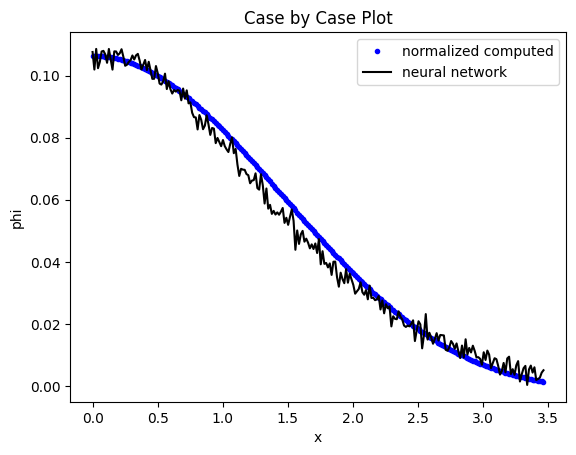

In [ ]:
import matplotlib.pyplot as plt
#plot case by case

#enter a case
tcase = 2346
plt.figure(1)
plt.title("Case by Case Plot")
plt.plot(solv1[tcase, :], sols_norm[tcase] , 'b.', label = "normalized computed")
print('t =', iv1[tcase], 'c = ', iv3[tcase])
plt.plot(solv1[tcase, :], yhat[tcase, :] , 'k-', label = "neural network")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.show()


In [ ]:
#this can be used to save your model
model.save("plane_IC_model.h5")
model.save("plane_IC_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#this can be used to improt a saved model
from keras.models import load_model
model = load_model('plane_IC_model.h5', custom_objects={'custom_loss_function': custom_loss_function})

The final block here allows the user to compute a case that was not provided in in the training data to see how the model behaves.

1/1 [==============================] - 0s 253ms/step


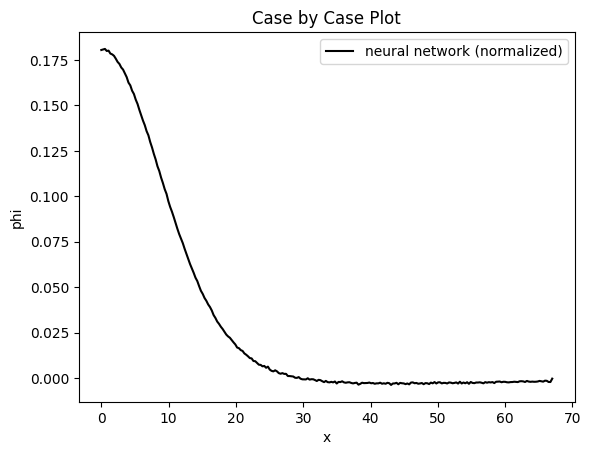

In [ ]:
# lets look at some individual test cases w/o computed data

#enter custom values
c = 1.2
t = 67

#normalizing
ics_case = np.array([[t,c]])
ics_case_norm = normalize(ics_case, 'l2')
ice_case_norm = ics_case_norm.transpose()

ycase = model.predict(ics_case_norm)

#plotting
import matplotlib.pyplot as plt

plt.figure(0)
plt.title("Case by Case Plot")
plt.plot(np.linspace(0, t, 250), ycase[0,:] , 'k-', label = "neural network (normalized)")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.show()
